In [2]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import calplot
import matplotlib.ticker 
from scipy.ndimage import gaussian_filter1d
sns.set()

In [3]:
data = pd.read_csv('./Assignment final/gadetraer.csv')
data['bydelsnavn'][data['bydelsnavn']=='Vesterbro-Kongens Enghave'] = 'Vesterbro'

/tmp/ipykernel_11924/2434176492.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bydelsnavn'][data['bydelsnavn']=='Vesterbro-Kongens Enghave'] = 'Vesterbro'


In [4]:
print(data.columns)
# data.head()

Index(['FID', 'id', 'traeart', 'slaegt', 'dansk_navn', 'slaegtsnavn',
       'planteaar', 'plantet_halvaar', 'garantiperioden_udloeber',
       'plantemetode', 'ejer', 'driftsorganisation', 'driftsplan_navn',
       'driftsaftale_edoc_nr', 'bemaerkning', 'andre_vaekstforhold',
       'fredet_beskyttet_trae', 'fredning_edoc_nr', 'trae_historie',
       'botanisk_interesse', 'donor', 'anledning', 'saerligt_trae',
       'saerlig_trae_bem', 'bydelsnavn', 'fredet_trae_foto', 'vejstatus',
       'ogc_fid', 'wkb_geometry'],
      dtype='object')


In [5]:
val = data['bemaerkning'][~data['bemaerkning'].isnull()].iloc[:10000]

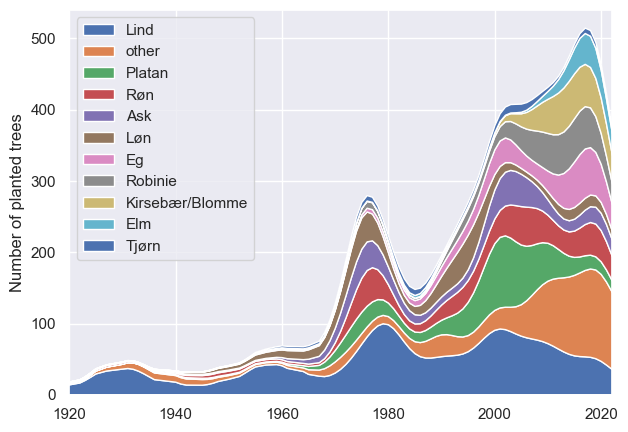

<Figure size 640x480 with 0 Axes>

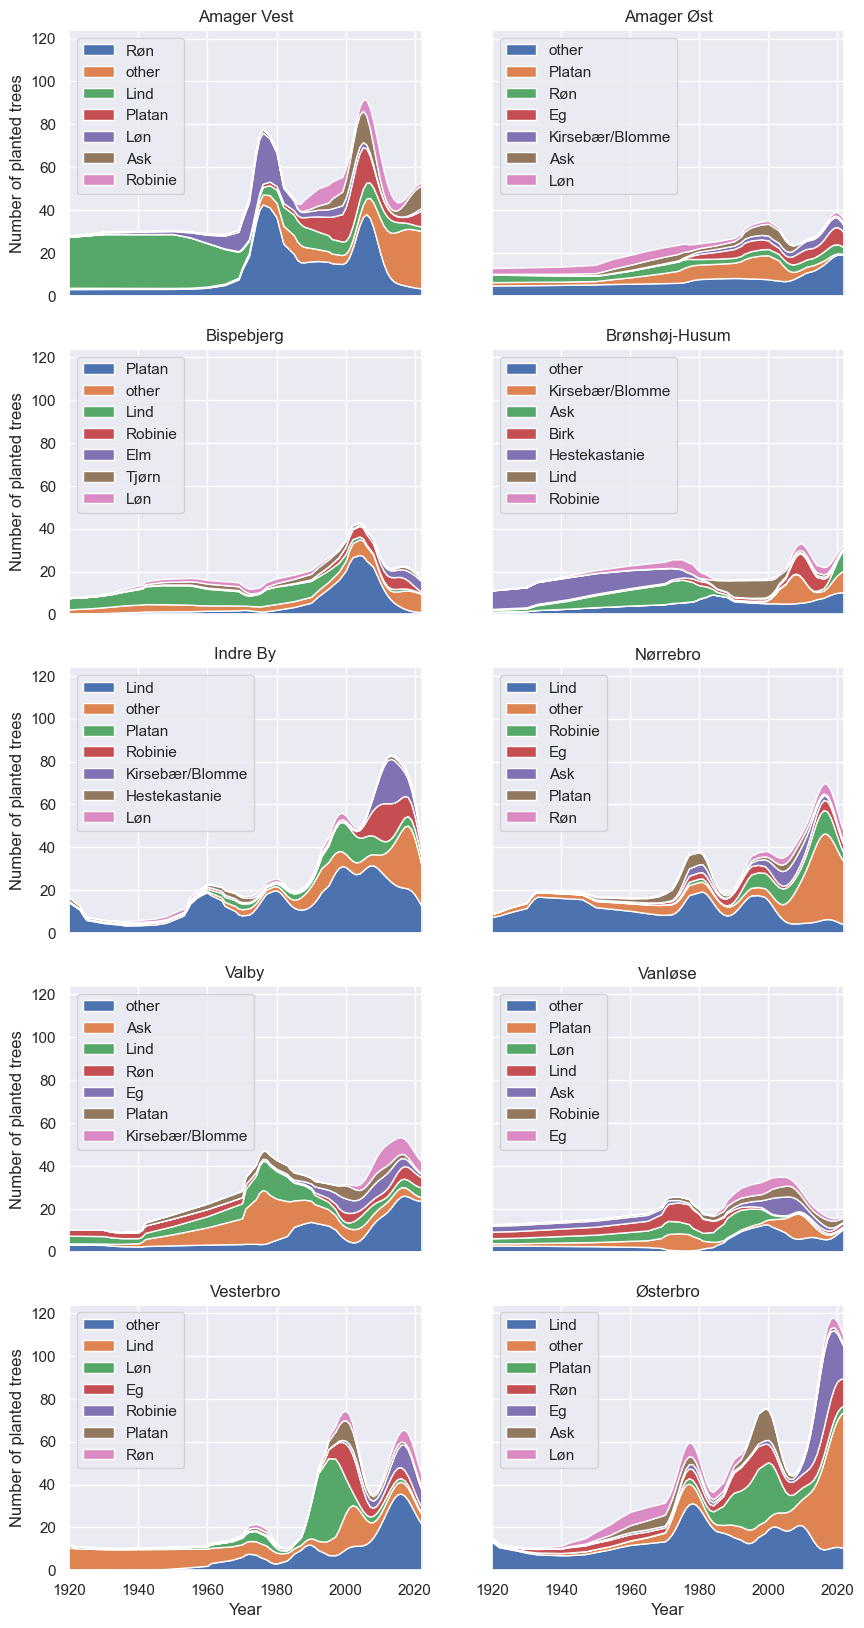

<Figure size 640x480 with 0 Axes>

In [10]:
# Data
def stacked_plot(num_spe, shape, save_path=None):
    datat = data['bydelsnavn']
    single = np.prod(shape)==1
    fig, axes = plt.subplots(*shape, dpi = 100, sharex=True, sharey=True, figsize=(10,20) if not single else (7,5))
    for k, region in enumerate(np.unique(datat)):
        if single:
            ax = axes
        else:
            ax = axes[k//2, k%2]
            ax.set_title(region)
        ax.set_xlim((1920,2022))
        if not k%2: ax.set_ylabel('Number of planted trees')
        if k==9 or k==8: ax.set_xlabel('Year')

        datay = data['planteaar']
        datas = data['slaegtsnavn']
        if not single:
            datay = datay[datat == region]
            datas = datas[datat == region]

        years = np.unique(datay)
        species, X = np.unique(datas, return_counts=True)
        sel = np.argsort(X)[::-1][:num_spe]
        other_amount = sum(X) - sum(X[sel])
        labels_sel = np.insert(species[sel], sum(other_amount < X[sel]),'other')

        ys = np.zeros((len(labels_sel), len(years)))
        for n, y in enumerate(years):
            nam, val = np.unique(datas[datay==y], return_counts=True)
            for name,v in zip(nam,val):
                ys[name==labels_sel, n] = v
            ys['other'==labels_sel, n] = sum(val) - np.sum(ys[:,n])
        # Plot
        ys = gaussian_filter1d(ys, 3)
        ax.stackplot(years,ys, labels=labels_sel)
        ax.legend(loc='upper left')
        if single: break
    plt.show()
    if not save_path is None:
        plt.savefig('./ToreVang.github.io/public/'+save_path+'.png')

# Check something does not add up with the others look at the first plot
stacked_plot(10, shape=(1,1), save_path='stacked_copenhagen')
stacked_plot( 6, shape=(5,2), save_path='stacked_regions')


In [14]:
# Define plotting functions
def plot(X, labs, title, ylab, bar=True, xstep=1, save_path=None):
    fig, ax = plt.subplots(dpi=70)
    axes = [ax, ax.twinx()] if len(X)>1 else [ax]
    plt.title(title, size=14)
    y_pos = np.arange(len(X[0]))
    width = 0.75/len(X)
    for i in range(len(X)):
        if bar: axes[i].bar(y_pos+i*width, X[i], width, color=f'C{i}')
        else: axes[i].plot(y_pos, gaussian_filter1d(X[i], 1), color=f'C{i}')
        axes[i].set_ylim(0)
        axes[i].set_ylabel(ylab[i], color=(f'C{i}' if len(X)>1 else 'k'), size=14)
        axes[i].set_xticks(y_pos[::xstep], labs[::xstep], rotation=40)
    if len(X)>1: 
        axes[1].set_yticks(np.linspace(axes[1].get_yticks()[0], axes[1].get_yticks()[-1], len(axes[0].get_yticks())))
        axes[0].set_yticks(np.linspace(axes[0].get_yticks()[0], axes[0].get_yticks()[-1], len(axes[0].get_yticks())))
        axes[1].grid(None)
    plt.show()
    if not save_path is None:
        plt.savefig('./ToreVang.github.io/public/'+save_path+'.png')

def barch(x, title, ylab, xx=None, cutoffx=None, cutoffl=None, bar=True, xstep=1,save_path=None):
    # Get data
    labs, X1, = np.unique(data[x], return_counts=True)
    if not xx is None: X2 = np.array([len(np.unique(data[xx][data[x]==i])) for i in labs])
    # Remove values related to counts or label
    if not cutoffl is None: 
        sel = (cutoffl[0] <= labs) & (cutoffl[1] >= labs)
        labs = labs[sel]; X1 = X1[sel]; X2 = X2[sel]
    if not cutoffx is None: 
        sel = X1 > cutoffx
        labs = labs[sel]; X1 = X1[sel]
    # Specific for year, there are a few missing values, fill out with zeros
    if x=='planteaar':
        labs_new = np.arange(cutoffl[0],cutoffl[1]+1)
        sel = np.isin(labs_new, labs)
        X1_new = np.zeros(len(sel)); X2_new = np.zeros(len(sel))
        X1_new[sel] = X1; X2_new[sel] = X2
        X1 = X1_new; X2 = X2_new; labs = labs_new
    # plot
    if isinstance(ylab, str): 
        ylab = [ylab]
        X = [X1]
    else: 
        X = [X1,X2]
    plot(X, labs, title, ylab, bar, xstep, save_path)


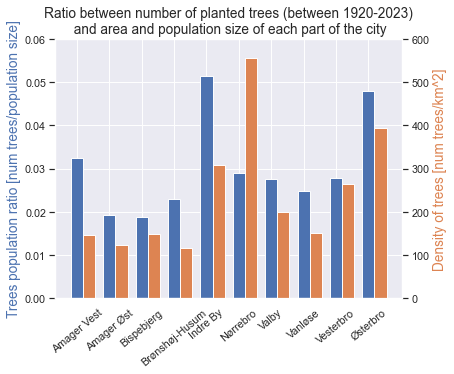

<Figure size 640x480 with 0 Axes>

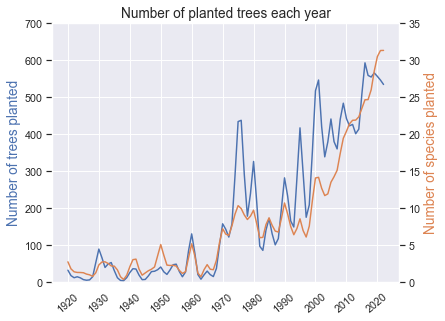

<Figure size 640x480 with 0 Axes>

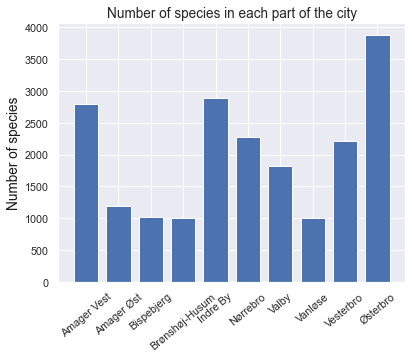

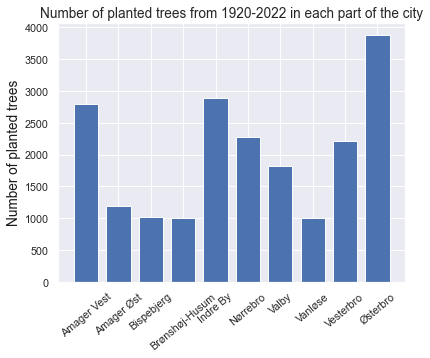

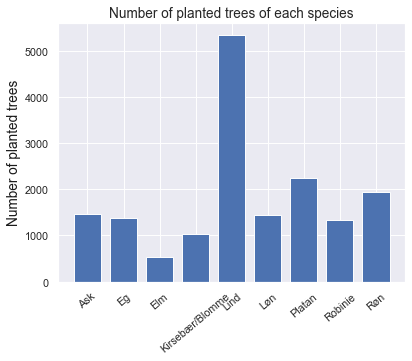

In [15]:
# make stacked area plot for all copenhagen
# Find dataset on wealth of 

# Make plots
labs, num_trees = np.unique(data['bydelsnavn'], return_counts=True)
population = [86668, 62197, 54346, 43933, 56446, 78583, 66435, 40633, 79646, 80605]
area = [19.36,  9.779, 6.828, 8.738, 9.416, 4.104, 9.232, 6.697, 8.355, 9.854]
plot((num_trees/population, num_trees/area), 
     labs, 
     ylab = ['Trees population ratio [num trees/population size]', 'Density of trees [num trees/km^2]'], 
     title = 'Ratio between number of planted trees (between 1920-2023)\n and area and population size of each part of the city',
     save_path = 'tree_density_tree_population_ratio')

barch('planteaar', 
      title = 'Number of planted trees each year',
      ylab = ['Number of trees planted','Number of species planted'],
      xx = 'slaegtsnavn', 
      bar=False, cutoffl=(1920,2022), xstep=10,
      save_path = 'tree_amount_tree_diversity')


barch('bydelsnavn', 
      title = 'Number of species in each part of the city', 
      ylab = 'Number of species',
      xx = 'slaegtsnavn')


barch('bydelsnavn', 
      title = 'Number of planted trees from 1920-2022 in each part of the city', 
      ylab = 'Number of planted trees')


barch('slaegtsnavn', 
      title = 'Number of planted trees of each species', 
      ylab = 'Number of planted trees', 
      cutoffx=500)


### Motivation

This dataset is about street trees in copenhagen from 1750-2023. It involves which types of tree, when and where they were planted, together with detailed information about who payed, how it was planted and its botanic value. 

The dataset is very intereseting due to size and detailed descriptions about many aspects of the trees, with its 29 variable. 

Since trees are very important for cities and the people around them, it would be usefull to know where and which trees are planted when moving. 

### Basic stats

The dataset contains many variables but when this is said many of the variables are mostly NaNs. This analysis does not require the use of any these very detailed variables that contains many NaNs. A few observations of trees planted in 1750 also exist but these are outliers and measurements were only reqularly noted from 1920. All observations before this year is deselected since the values are not consistent and are also very few. 

In this analysis we only make use of the attributes "slaegtsnavn" (tree sort) and "planteaar" (year). None of these contains any missing values.

Stacked area plot:
It is very clear that planting of trees comes in project, in a few year a very large amount of trees where planted while other years almost none trees where planted. In order to make a stacked area plot, a smoothing was nessecary, in this case a simple gaussian filter was used to even out the peaks in the plot. 



